In [262]:

from typing import Dict

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, losses

from src.spectrogram import Spectrogram, split_spectrogram
from src.spectrum_painting import take_frequencies, downsample_spectrogram, augment_spectrogram, paint_spectrogram, \
    digitize_spectrogram

In [263]:
def convert_complex_numbers(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Convert complex numbers strings where 'i' (Math convention) is used to use 'j' (Engineering convention) instead
    and convert it to numpy complex number type.
    :param frame: A Pandas dataframe
    :return: A data frame containing numpy complex numbers.
    """
    return frame.map(lambda row: np.csingle(row.replace("i", "j")))[0]


# Read the data where b = Bluetooth, w = WiFi, z = Zigbee. So the frame
# called 'zb' means it is the spectrogram containing Zigbee and Bluetooth
# signals.
data_frames: Dict[str, pd.DataFrame] = {
    "b": pd.read_csv("data/csv/B_SNR30.csv", sep=",", header=None, dtype=str),
    "bw": pd.read_csv("data/csv/BW_SNR30.csv", sep=",", header=None, dtype=str),
    "w": pd.read_csv("data/csv/W_SNR30.csv", sep=",", header=None, dtype=str),
    "z": pd.read_csv("data/csv/Z_SNR30.csv", sep=",", header=None, dtype=str),
    "zb": pd.read_csv("data/csv/ZB_SNR30.csv", sep=",", header=None, dtype=str),
    "zw": pd.read_csv("data/csv/ZW_SNR30.csv", sep=",", header=None, dtype=str),
    "zbw": pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)
}

# Convert complex number notation
data_frames = {key: convert_complex_numbers(frame) for key, frame in data_frames.items()}

In [264]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

Number of training images: 105


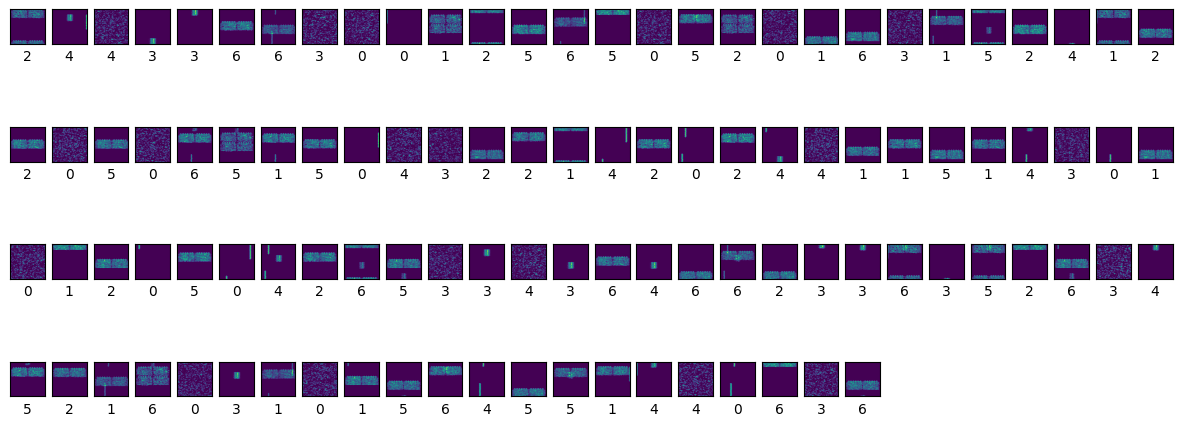

In [274]:
from src.spectrogram import create_spectrogram

# Sampling frequency
fs = 20000000  # 20MHz

spectrograms: Dict[str, Spectrogram] = {key: create_spectrogram(frame, fs) for key, frame in data_frames.items()}

np.random.seed(42)

training_data: [(int, npt.NDArray[npt.NDArray[np.float32]])] = []

downsample_resolution = 60

K = 3
L = 1
D = 1

for (class_index, (label, spec)) in enumerate(spectrograms.items()):
    middle: int = len(spec.values) // 2
    start_freq: int = middle - 30
    end_freq: int = middle + 30

    spec = take_frequencies(spec, start_freq, end_freq)

    slices = split_spectrogram(spec, duration=500)

    downsampled_slices = [downsample_spectrogram(s.values, downsample_resolution) for s in slices]
    augmented_slices = [augment_spectrogram(s, K, L, D) for s in downsampled_slices]

    painted_slices = [paint_spectrogram(original, augmented) for (original, augmented) in
                      list(zip(downsampled_slices, augmented_slices))]

    digitized_slices = [digitize_spectrogram(s, 256) for s in augmented_slices]

    for s in digitized_slices:
        training_data.append((class_index, s))

training_data = np.array(training_data, dtype=tuple)
np.random.shuffle(training_data)

print(f"Number of training images: {len(training_data)}")

plt.figure(figsize=(15, 15))
for i in range(len(training_data)):
    (label, image) = training_data[i]
    plt.subplot(10, 28, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [275]:
image_shape = training_data[0][1].shape
# The input shape to the CNN is the height, width and number of color channels. The spectrograms
# only have one color channel.
input_shape = (image_shape[0], image_shape[1], 1)
print(input_shape)

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(7, 7), activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the 3D image output to 1 dimension
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

label_count = len(spectrograms)
model.add(layers.Dense(label_count))
model.summary()

(60, 60, 1)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_101 (Conv2D)             │ (None, 54, 54, 32)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 54, 54, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 23, 23, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,487 (611.28 KB)

 Trainable params: 156,167 (610.03 KB)

 Non-trainable params: 320 (1.25 KB)

In [276]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
train_labels = training_data[:, 0].astype(dtype=np.uint8)
# Getting an axis of an array returns an array-of-arrays and not 2D array so stack
# them together.
train_images = np.stack(training_data[:, 1])

history = model.fit(x=train_images, y=train_labels, epochs=10, validation_split=0.2)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.1592 - loss: 2.8048 - val_accuracy: 0.1905 - val_loss: 5.4686
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4232 - loss: 1.5811 - val_accuracy: 0.2381 - val_loss: 6.1508
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3800 - loss: 1.2944 - val_accuracy: 0.2381 - val_loss: 7.1995
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4706 - loss: 1.1565 - val_accuracy: 0.2857 - val_loss: 6.9074
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4885 - loss: 1.0644 - val_accuracy: 0.3333 - val_loss: 7.3437
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5590 - loss: 0.9563 - val_accuracy: 0.1905 - val_loss: 7.5381
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6023 - loss: 0.8610 - val_accuracy: 0.1905 - val_loss: 6.6193
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5828 - loss: 0.8537 - val_accuracy: 0.1429 - val_loss: 6.0106
